## Import packages

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
from tqdm import tqdm
import os

os.makedirs("processed_data", exist_ok=True)

## Helper functions

In [9]:
def flatten(xss):
    return [x for xs in xss for x in xs]

## Import raw data

In [10]:
#Nextcloud credentials
username = 'algarrid'
password = 'faunistico'

file_url = (
    'https://cloud.ilabt.imec.be/remote.php/dav/files/'+
    'af741990-37f9-103d-9441-9bec5c4808a7/ExperimentsData/'+
    'cwir_dataset/behavioural_data/experiment_trials.csv'            
)

response = requests.get(file_url, auth=(username, password))

# Check if the request was successful
if response.status_code == 200:
    # Stream the content directly into a pandas DataFrame
    csv_content = StringIO(response.text)
    df_raw_behavioural_data = pd.read_csv(csv_content)

    # Now `df` is your DataFrame containing the CSV data
    print("Raw behavioural data downloaded")  # Example: print the first few rows
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

Raw behavioural data downloaded


#### Clean raw data

In [11]:
# Rule out trials in which the full-screen mode was exited
df_raw_behavioural_data = df_raw_behavioural_data[df_raw_behavioural_data['FullScreenExited'] == 0]

# Rule out trials from discarded participants
discarded_participants_list = [14,19]
df_raw_behavioural_data = df_raw_behavioural_data[~df_raw_behavioural_data['ParticipantID'].isin(discarded_participants_list)] 

par_ids = np.unique(df_raw_behavioural_data['ParticipantID'])
n_par = len(par_ids)

output_path = os.path.join("processed_data", "processed_experiment_data.csv")
df_raw_behavioural_data.to_csv(output_path, index=False)

## Clean risky decision-making data

##### Plot raw distribution of Reaction Times

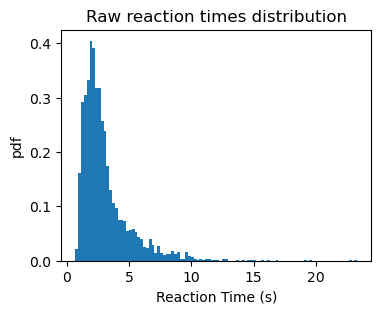

Minimum Reaction Time: 0.6905999999940395
Maximum Reaction Time: 23.33560000002384


In [13]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_raw_behavioural_data['ResponseTimeGamble'], bins = 100, density = True)
plt.title("Raw reaction times distribution")
plt.ylabel("pdf")
plt.xlabel("Reaction Time (s)")
plt.show()

print("Minimum Reaction Time: "+str(min(df_raw_behavioural_data['ResponseTimeGamble'])))
print("Maximum Reaction Time: "+str(max(df_raw_behavioural_data['ResponseTimeGamble'])))

##### Detect and drop outlier trials

In [14]:
# Take the log of RT
df_raw_behavioural_data['Log_rt'] = np.log(df_raw_behavioural_data['ResponseTimeGamble'])

rows_to_remove = []

for par in par_ids:

    df_par = df_raw_behavioural_data[df_raw_behavioural_data['ParticipantID'] == par]
    
    # Compute median and MAD per participant
    median_log_rt = np.median(df_par['Log_rt'])
    mad_log_rt = np.median(np.abs(df_par['Log_rt'] - median_log_rt))

    # Define the bounds for outliers
    lower_bound = median_log_rt - 4 * mad_log_rt
    upper_bound = median_log_rt + 4 * mad_log_rt

    outlier_rounds_per_participant = df_par[(df_par['Log_rt'] < lower_bound) | (df_par['Log_rt'] > upper_bound)]['ExperimentRoundNumber']
    outlier_row_indices = df_raw_behavioural_data[(df_raw_behavioural_data['ParticipantID'] == par) & (df_raw_behavioural_data['ExperimentRoundNumber'].isin(outlier_rounds_per_participant))].index
    
    rows_to_remove.append(outlier_row_indices.tolist())

rows_to_remove = flatten(rows_to_remove)

df_processed_risky_dm_task = df_raw_behavioural_data.drop(rows_to_remove).reset_index(drop=True)

##### Plot reaction time distribution without outlier trials

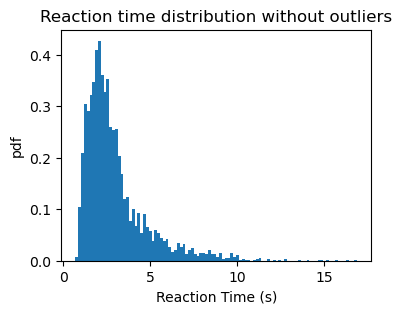

Minimum Reaction Time: 0.6905999999940395
Maximum Reaction Time: 16.89709999999404


In [15]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_processed_risky_dm_task['ResponseTimeGamble'], bins = 100, density = True)
plt.title("Reaction time distribution without outliers")
plt.ylabel("pdf")
plt.xlabel("Reaction Time (s)")
plt.show()

print("Minimum Reaction Time: "+str(min(df_processed_risky_dm_task['ResponseTimeGamble'])))
print("Maximum Reaction Time: "+str(max(df_processed_risky_dm_task['ResponseTimeGamble'])))

##### Plot number of valid risky decision-making task trials per participant

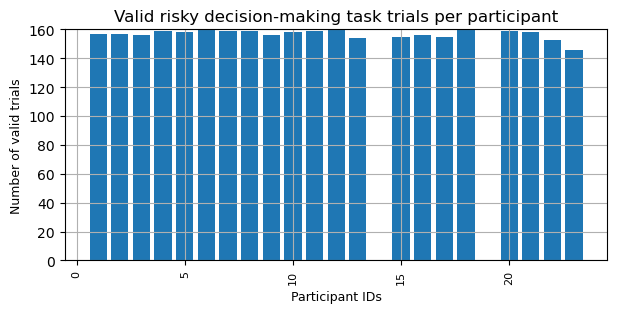

In [16]:
num_valid_rounds_per_par = []

for par in par_ids:
    df_par = df_processed_risky_dm_task[df_processed_risky_dm_task['ParticipantID'] == par]
    num_valid_rounds = len(df_par)
    num_valid_rounds_per_par.append(num_valid_rounds)


plt.figure(figsize=(7, 3)) 
plt.bar(par_ids, num_valid_rounds_per_par)  # Create the bar chart

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=90,fontsize=8)

# Optional: Add labels to make the plot more informative
plt.ylim(0,160)
plt.xlabel('Participant IDs',fontsize = 9)
plt.ylabel('Number of valid trials', fontsize = 9)
plt.title('Valid risky decision-making task trials per participant')
plt.grid()
plt.show()

In [17]:
print("Percentage of risky decision-making task data kept: "+str(len(df_processed_risky_dm_task)/(160*n_par)))

Percentage of risky decision-making task data kept: 0.9803571428571428


#### Save processed risky decision-making task data

In [18]:
output_path = os.path.join("processed_data", "processed_risky_dm_task_data.csv")
df_processed_risky_dm_task.to_csv(output_path, index=False)

## Clean reproduction task data

##### Plot raw distribution of reproduced times

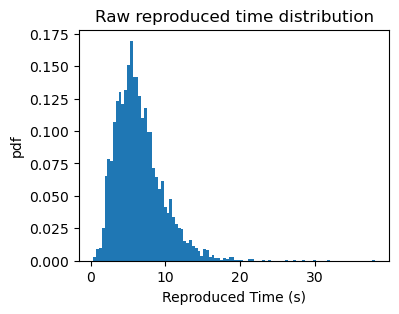

Minimum Reproduced Time: 0.3568999999985099
Maximum Reproduced Time: 38.00020000004768


In [19]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_raw_behavioural_data['ReproducedTime'], bins = 100, density = True)
plt.title("Raw reproduced time distribution")
plt.ylabel("pdf")
plt.xlabel("Reproduced Time (s)")
plt.show()

print("Minimum Reproduced Time: "+str(min(df_raw_behavioural_data['ReproducedTime'])))
print("Maximum Reproduced Time: "+str(max(df_raw_behavioural_data['ReproducedTime'])))

##### Detect and drop outlier trials

In [20]:
# Take the log of ReproT
df_raw_behavioural_data['Log_ReproTime'] = np.log(df_raw_behavioural_data['ReproducedTime'])

rows_to_remove = []

for par in par_ids:

    df_par = df_raw_behavioural_data[df_raw_behavioural_data['ParticipantID'] == par]
    
    # Compute median and MAD per participant
    median_log_repro_t = np.median(df_par['Log_ReproTime'])
    mad_log_repro_t = np.median(np.abs(df_par['Log_ReproTime'] - median_log_repro_t))

    # Define the bounds for outliers
    lower_bound = median_log_repro_t - 4 * mad_log_repro_t
    upper_bound = median_log_repro_t + 4 * mad_log_repro_t

    outlier_rounds_per_participant = df_par[(df_par['Log_ReproTime'] < lower_bound) | (df_par['Log_ReproTime'] > upper_bound)]['ExperimentRoundNumber']
    outlier_row_indices = df_raw_behavioural_data[(df_raw_behavioural_data['ParticipantID'] == par) & (df_raw_behavioural_data['ExperimentRoundNumber'].isin(outlier_rounds_per_participant))].index
    
    rows_to_remove.append(outlier_row_indices.tolist())

rows_to_remove = flatten(rows_to_remove)

df_processed_reproduction_task = df_raw_behavioural_data.drop(rows_to_remove)

##### Plot reproduced time distribution without outlier trials

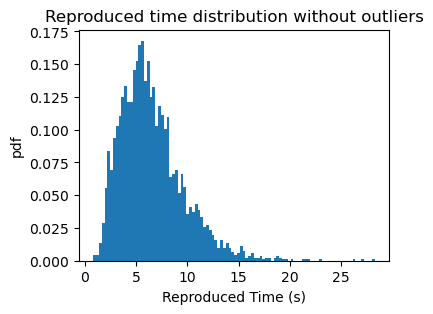

Minimum Reproduced Time: 0.8098000000715255
Maximum Reproduced Time: 28.287800000071524


In [21]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_processed_reproduction_task['ReproducedTime'], bins = 100, density = True)
plt.title("Reproduced time distribution without outliers")
plt.ylabel("pdf")
plt.xlabel("Reproduced Time (s)")
plt.show()

print("Minimum Reproduced Time: "+str(min(df_processed_reproduction_task['ReproducedTime'])))
print("Maximum Reproduced Time: "+str(max(df_processed_reproduction_task['ReproducedTime'])))

##### Plot number of valid reproduction task trials per participant

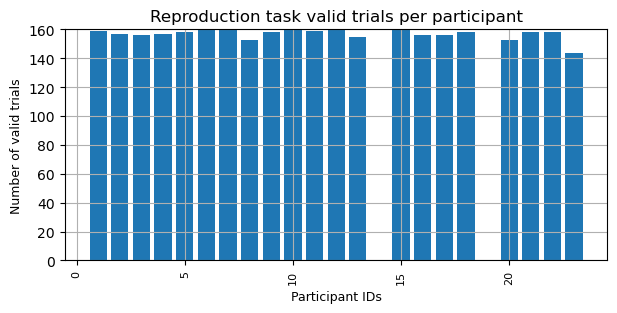

In [22]:
num_valid_rounds_per_par = []

for par in par_ids:
    df_par = df_processed_reproduction_task[df_processed_reproduction_task['ParticipantID'] == par]
    num_valid_rounds = len(df_par)
    num_valid_rounds_per_par.append(num_valid_rounds)


plt.figure(figsize=(7, 3)) 
plt.bar(par_ids, num_valid_rounds_per_par)  # Create the bar chart

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=90,fontsize=8)

# Optional: Add labels to make the plot more informative
plt.ylim(0,160)
plt.xlabel('Participant IDs',fontsize = 9)
plt.ylabel('Number of valid trials', fontsize = 9)
plt.title('Reproduction task valid trials per participant')
plt.grid()
plt.show()

In [23]:
print("Percentage of of reproduction task data kept: "+str(len(df_processed_reproduction_task)/(160*n_par)))

Percentage of of reproduction task data kept: 0.9806547619047619


##### Save processed reproduction task data

In [24]:
output_path = os.path.join("processed_data", "processed_reproduction_task_data.csv")
df_processed_reproduction_task.to_csv(output_path, index=False)